In [1]:
from glob import glob
import pandas as pd
from scipy.stats import spearmanr
from statsmodels.sandbox.stats.multicomp import multipletests
import numpy as np
import seaborn as sns

sns.set_style('whitegrid')

def p_adjust(pvalues, method='fdr_bh'):
    res = multipletests(pvalues, method=method)
    return np.array(res[1], dtype=float)

# Correlating Kraken abundances with continuous vaccine titers

##### Michael Shaffer
##### 7/21/2022
##### Merck ESC, Sys bio group

To find if any bacterial taxa are correlated with vaccine response we will pick time points (2, 4, 6, 8 and 12 months) and correlate the bacterial abundances at those timepoints with continuous vaccine response at one year.

## Read in data

In [2]:
meta = pd.read_csv('../../data/metadata/stool/stool_metadata.csv', index_col='SampleID')
meta = pd.concat([meta,
                  pd.read_csv('../../data/metadata/stool/stool_abx_usage.csv', index_col='SampleID'),
                  pd.read_csv('../../data/metadata/stool/stool_titers_yr2.csv', index_col='SampleID')],
                 axis=1)
meta['VR_group'] = meta['VR_group'].fillna('Not Measured')
meta = meta.sort_values(['BabyN', 'age_at_collection'])
meta = meta.loc[~pd.isna(meta['median_mmNorm'])]
meta.head()

,SubmissionType,SampleNumber,SampleIDValidation,DiversigenCheckInSampleName,BoxLocation,SampleType,SampleSource,SequencingType,BabyN,BabyN_checked,...,PCV ST9V_mmNorm,PCV ST14_mmNorm,PCV ST18C_mmNorm,PCV ST19A_mmNorm,PCV ST19F_mmNorm,PCV ST23F_mmNorm,median_mmNorm,median_mmNorm_DTAPHib,median_mmNorm_PCV,VR_group
SampleID,,,,,,,,,,,,,,,,,,,,,
103_V3,Primary in Tube,149,NaN,NaN,"Box 11, A6",Stool,Human Infant,MetaG,103,NaN,...,0.277753,0.146465,0.086356,0.035467,0.057453,0.300910,0.190854,0.326317,0.146465,NVR
103_V9,Primary in Tube,186,NaN,NaN,"Box 12, B1",Stool,Human Infant,MetaG,103,NaN,...,0.277753,0.146465,0.086356,0.035467,0.057453,0.300910,0.190854,0.326317,0.146465,NVR
103_S1,Primary in Tube,225,NaN,NaN,"Box 13, B4",Stool,Human Infant,MetaG,103,NaN,...,0.277753,0.146465,0.086356,0.035467,0.057453,0.300910,0.190854,0.326317,0.146465,NVR
103_V10,Primary in Tube,241,NaN,NaN,"Box 13, E1",Stool,Human Infant,MetaG,103,NaN,...,0.277753,0.146465,0.086356,0.035467,0.057453,0.300910,0.190854,0.326317,0.146465,NVR
108_V2,Primary in Tube,6,NaN,NaN,"Box 7, A6",Stool,Human Infant,MetaG,108,NaN,...,0.871843,0.366194,0.164958,0.041692,0.063590,0.371471,0.168430,0.172291,0.164958,NVR


In [3]:
kraken_genus_abunds = pd.read_csv('../../data/stool/kraken_taxa_level_abunds/kraken_genus_abunds.tsv', sep='\t', index_col=0)
kraken_genus_abunds = kraken_genus_abunds[meta.query("`gt_2.5` == True").index]
print(kraken_genus_abunds.shape)
display(kraken_genus_abunds.head())

(971, 450)


,103_V9,103_S1,103_V10,108_V2,108_V3,108_V4,108_V5,108_V6,108_V7,108_S1,...,264_V5,264_S1,264_S1F,264_V7,264_S2,264_S2F,264_V9,264_V10,264_V11,264_V12
d__Bacteria|g__Thermobaculum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Acidobacterium,1.0,0.0,3.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,4.0
d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Candidatus_Koribacter,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.0,6.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,5.0
d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Granulicella,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,13.0,6.0
d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Terriglobus,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,14.0,3.0


In [4]:
kraken_family_abunds = pd.read_csv('../../data/stool/kraken_taxa_level_abunds/kraken_family_abunds.tsv', sep='\t', index_col=0)
kraken_family_abunds = kraken_family_abunds[meta.query("`gt_2.5` == True").index]
print(kraken_family_abunds.shape)
display(kraken_family_abunds.head())

(320, 450)


,103_V9,103_S1,103_V10,108_V2,108_V3,108_V4,108_V5,108_V6,108_V7,108_S1,...,264_V5,264_S1,264_S1F,264_V7,264_S2,264_S2F,264_V9,264_V10,264_V11,264_V12
d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae,1.0,2.0,6.0,0.0,0.0,2.0,2.0,81.0,6.0,6.0,...,0.0,2.0,0.0,0.0,1.0,0.0,6.0,3.0,39.0,20.0
d__Bacteria|p__Acidobacteria|c__Solibacteres|o__Solibacterales|f__Solibacteraceae,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
d__Bacteria|p__Actinobacteria|c__Acidimicrobiia|o__Acidimicrobiales|f__Acidimicrobiaceae,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
d__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Acidothermales|f__Acidothermaceae,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
d__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae,24.0,9.0,60.0,0.0,1.0,45.0,207.0,27.0,42.0,16.0,...,3.0,7127.0,1752.0,1144.0,684.0,1817.0,32.0,33.0,33.0,48.0


In [5]:
in_both = set(meta.index) & set(kraken_genus_abunds.columns)
meta_matched = meta.loc[in_both]
print(meta_matched.shape)

(450, 72)


/var/folders/6t/1w2t3qmd1rx81mfw9sq_tfpr0000gn/T/ipykernel_12569/1022001642.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  meta_matched = meta.loc[in_both]


In [6]:
meta_v5 = meta_matched.query("VisitCode == 'V5'")
meta_v6 = meta_matched.query("VisitCode == 'V6'")
meta_v7 = meta_matched.query("VisitCode == 'V7'")
meta_v9 = meta_matched.query("VisitCode == 'V9'")

meta_PCV = meta_matched.loc[~pd.isna(meta_matched['median_mmNorm_PCV'])]
meta_PCV_v5 = meta_PCV.query("VisitCode == 'V5'")
meta_PCV_v6 = meta_PCV.query("VisitCode == 'V6'")
meta_PCV_v7 = meta_PCV.query("VisitCode == 'V7'")
meta_PCV_v9 = meta_PCV.query("VisitCode == 'V9'")

## Genus level correlations with median of all titers

In [7]:
kraken_genus_abunds_v5 = kraken_genus_abunds[meta_v5.index]
kraken_genus_abunds_v5 = kraken_genus_abunds_v5.loc[(kraken_genus_abunds_v5 > 0).sum(axis=1) > kraken_genus_abunds_v5.shape[1]*.2]
v5_correlations = kraken_genus_abunds_v5.transpose().apply(spearmanr, b=meta_v5['median_mmNorm']).transpose()
v5_correlations.columns = ['rho', 'p_value']
v5_correlations['p_adj'] = p_adjust(v5_correlations['p_value'])
v5_correlations = v5_correlations.sort_values('p_value')
v5_correlations.head()

,rho,p_value,p_adj
d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Actinobacillus,-0.489087,0.004502,0.957447
d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Xanthomonadaceae|g__Luteimonas,0.475070,0.006003,0.957447
d__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Coriobacteriales|f__Atopobiaceae|g__Atopobium,-0.417568,0.017410,0.984797
d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcus,0.386530,0.028868,0.984797
d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Aggregatibacter,-0.375472,0.034204,0.984797


In [8]:
kraken_genus_abunds_v6 = kraken_genus_abunds[meta_v6.index]
kraken_genus_abunds_v6 = kraken_genus_abunds_v6.loc[(kraken_genus_abunds_v6 > 0).sum(axis=1) > kraken_genus_abunds_v6.shape[1]*.2]
v6_correlations = kraken_genus_abunds_v6.transpose().apply(spearmanr, b=meta_v6['median_mmNorm']).transpose()
v6_correlations.columns = ['rho', 'p_value']
v6_correlations['p_adj'] = p_adjust(v6_correlations['p_value'])
v6_correlations = v6_correlations.sort_values('p_value')
v6_correlations.head()

,rho,p_value,p_adj
d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Shigella,-0.511845,0.001973,0.516984
d__Bacteria|p__Planctomycetes|c__Planctomycetia|o__Planctomycetales|f__Isosphaeraceae|g__Paludisphaera,0.493001,0.003053,0.516984
d__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Pseudonocardiales|f__Pseudonocardiaceae|g__Pseudonocardia,0.478361,0.004215,0.516984
d__Bacteria|p__Cyanobacteria|c__Gloeobacteria|o__Gloeobacterales|f__Gloeobacteraceae|g__Gloeobacter,0.462296,0.005911,0.522276
d__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Polaromonas,0.444829,0.008390,0.522276


In [9]:
kraken_genus_abunds_v7 = kraken_genus_abunds[meta_v7.index]
kraken_genus_abunds_v7 = kraken_genus_abunds_v7.loc[(kraken_genus_abunds_v7 > 0).sum(axis=1) > kraken_genus_abunds_v7.shape[1]*.2]
v7_correlations = kraken_genus_abunds_v7.transpose().apply(spearmanr, b=meta_v7['median_mmNorm']).transpose()
v7_correlations.columns = ['rho', 'p_value']
v7_correlations['p_adj'] = p_adjust(v7_correlations['p_value'])
v7_correlations = v7_correlations.sort_values('p_value')
v7_correlations.head()

,rho,p_value,p_adj
d__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Polaromonas,0.427681,0.007398,0.986093
d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnoclostridium,0.413503,0.009866,0.986093
d__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|g__Paucibacter,0.403081,0.012100,0.986093
d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Shigella,-0.396782,0.013648,0.986093
d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Pectobacteriaceae|g__Pectobacterium,-0.369240,0.022525,0.986093


In [10]:
kraken_genus_abunds_v9 = kraken_genus_abunds[meta_v9.index]
kraken_genus_abunds_v9 = kraken_genus_abunds_v9.loc[(kraken_genus_abunds_v9 > 0).sum(axis=1) > kraken_genus_abunds_v9.shape[1]*.2]
v9_correlations = kraken_genus_abunds_v9.transpose().apply(spearmanr, b=meta_v9['median_mmNorm']).transpose()
v9_correlations.columns = ['rho', 'p_value']
v9_correlations['p_adj'] = p_adjust(v9_correlations['p_value'])
v9_correlations = v9_correlations.sort_values('p_value')
v9_correlations.head()

,rho,p_value,p_adj
d__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Spirochaetales|f__Spirochaetaceae|g__Spirochaeta,0.510163,0.001256,0.276897
d__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Planococcaceae|g__Planococcus,0.492807,0.001943,0.276897
d__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Streptosporangiales|f__Nocardiopsaceae|g__Nocardiopsis,0.486859,0.002245,0.276897
d__Bacteria|p__Firmicutes|g__Ndongobacter,0.485478,0.002321,0.276897
d__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Nitrosomonadales|f__Nitrosomonadaceae|g__Nitrosomonas,0.482673,0.002481,0.276897


Nothing is significant at the genus level.

## Family level correlations with median of all titers

In [11]:
kraken_family_abunds_v5 = kraken_family_abunds[meta_v5.index]
kraken_family_abunds_v5 = kraken_family_abunds_v5.loc[(kraken_family_abunds_v5 > 0).sum(axis=1) > kraken_family_abunds_v5.shape[1]*.2]
v5_correlations = kraken_family_abunds_v5.transpose().apply(spearmanr, b=meta_v5['median_mmNorm']).transpose()
v5_correlations.columns = ['rho', 'p_value']
v5_correlations['p_adj'] = p_adjust(v5_correlations['p_value'])
v5_correlations = v5_correlations.sort_values('p_value')
v5_correlations.head()

,rho,p_value,p_adj
d__Bacteria|p__Synergistetes|c__Synergistia|o__Synergistales|f__Synergistaceae,0.450521,0.009665,0.790964
d__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfuromonadales|f__Desulfuromonadaceae,0.437739,0.012225,0.790964
d__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Propionibacteriales|f__Propionibacteriaceae,-0.416950,0.017594,0.790964
d__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfovibrionales|f__Desulfovibrionaceae,0.410009,0.019774,0.790964
d__Bacteria|p__Verrucomicrobia|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Akkermansiaceae,0.351681,0.048402,0.893075


In [12]:
kraken_family_abunds_v6 = kraken_family_abunds[meta_v6.index]
kraken_family_abunds_v6 = kraken_family_abunds_v6.loc[(kraken_family_abunds_v6 > 0).sum(axis=1) > kraken_family_abunds_v6.shape[1]*.2]
v6_correlations = kraken_family_abunds_v6.transpose().apply(spearmanr, b=meta_v6['median_mmNorm']).transpose()
v6_correlations.columns = ['rho', 'p_value']
v6_correlations['p_adj'] = p_adjust(v6_correlations['p_value'])
v6_correlations = v6_correlations.sort_values('p_value')
v6_correlations.head()

,rho,p_value,p_adj
d__Bacteria|p__Planctomycetes|c__Planctomycetia|o__Planctomycetales|f__Isosphaeraceae,0.545752,0.000843,0.150818
d__Bacteria|p__Cyanobacteria|c__Gloeobacteria|o__Gloeobacterales|f__Gloeobacteraceae,0.462296,0.005911,0.519828
d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Alteromonadales|f__Shewanellaceae,-0.435095,0.010121,0.519828
d__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfarculales|f__Desulfarculaceae,0.427765,0.011616,0.519828
d__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Rhodocyclales|f__Azonexaceae,-0.386339,0.024014,0.797001


In [13]:
kraken_family_abunds_v7 = kraken_family_abunds[meta_v7.index]
kraken_family_abunds_v7 = kraken_family_abunds_v7.loc[(kraken_family_abunds_v7 > 0).sum(axis=1) > kraken_family_abunds_v7.shape[1]*.2]
v7_correlations = kraken_family_abunds_v7.transpose().apply(spearmanr, b=meta_v7['median_mmNorm']).transpose()
v7_correlations.columns = ['rho', 'p_value']
v7_correlations['p_adj'] = p_adjust(v7_correlations['p_value'])
v7_correlations = v7_correlations.sort_values('p_value')
v7_correlations.head()

,rho,p_value,p_adj
d__Bacteria|p__Thermodesulfobacteria|c__Thermodesulfobacteria|o__Thermodesulfobacteriales|f__Thermodesulfobacteriaceae,0.399964,0.012846,0.986259
d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Yersiniaceae,-0.365378,0.024087,0.986259
d__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Intrasporangiaceae,-0.332334,0.041494,0.986259
d__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Methylocystaceae,0.325585,0.046074,0.986259
d__Bacteria|p__Cyanobacteria|o__Synechococcales|f__Leptolyngbyaceae,0.325235,0.046322,0.986259


In [14]:
kraken_family_abunds_v9 = kraken_family_abunds[meta_v9.index]
kraken_family_abunds_v9 = kraken_family_abunds_v9.loc[(kraken_family_abunds_v9 > 0).sum(axis=1) > kraken_family_abunds_v9.shape[1]*.2]
v9_correlations = kraken_family_abunds_v9.transpose().apply(spearmanr, b=meta_v9['median_mmNorm']).transpose()
v9_correlations.columns = ['rho', 'p_value']
v9_correlations['p_adj'] = p_adjust(v9_correlations['p_value'])
v9_correlations = v9_correlations.sort_values('p_value')
v9_correlations.head()

,rho,p_value,p_adj
d__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Planococcaceae,0.484540,0.002373,0.248471
d__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Streptosporangiales|f__Nocardiopsaceae,0.471896,0.003192,0.248471
d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Cellvibrionales|f__Cellvibrionaceae,0.465753,0.003671,0.248471
d__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Nitrosomonadales|f__Nitrosomonadaceae,0.458655,0.004303,0.248471
d__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Aerococcaceae,0.429960,0.007907,0.320405


There are three significant results but they are all ocean bacteria. These are likely artifacts of an old and incomplete Kraken database.

### Dig into genuses within Erythrobacteraceae

In [15]:
erythrobacteraceae_genuses = [i for i in kraken_genus_abunds_v9.index
                              if 'd__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Erythrobacteraceae' in i]
erythrobacteraceae_genuses_v9 = pd.concat((kraken_genus_abunds_v9.loc[erythrobacteraceae_genuses].transpose(), meta_v9['median_mmNorm']), axis=1)

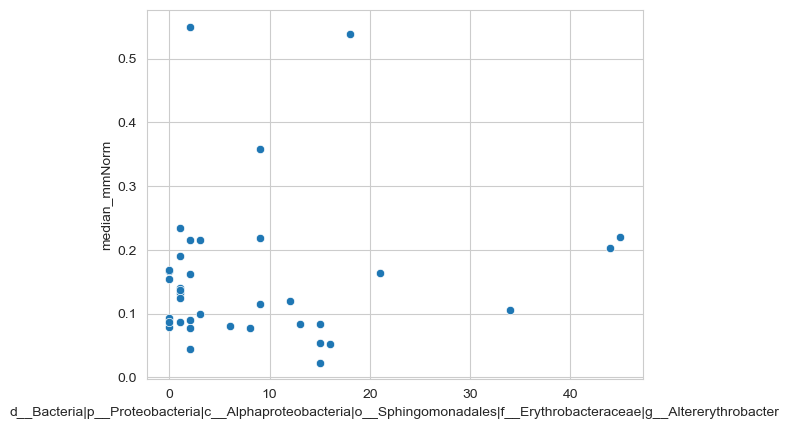

In [16]:
_ = sns.scatterplot(x='d__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Erythrobacteraceae|g__Altererythrobacter', y='median_mmNorm', data=erythrobacteraceae_genuses_v9)

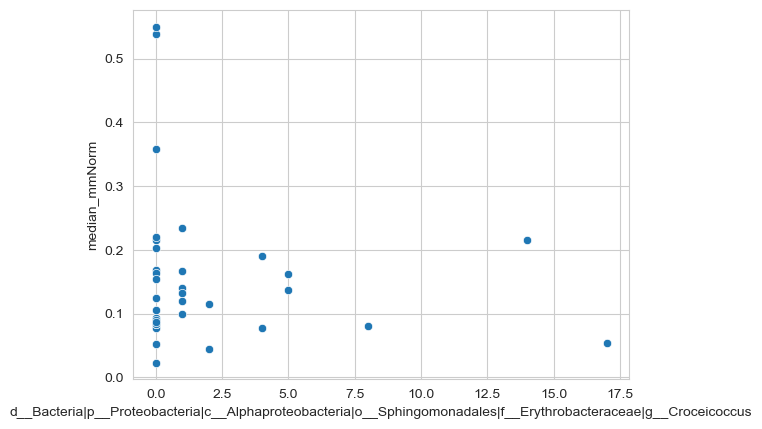

In [17]:
_ = sns.scatterplot(x='d__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Erythrobacteraceae|g__Croceicoccus', y='median_mmNorm', data=erythrobacteraceae_genuses_v9)

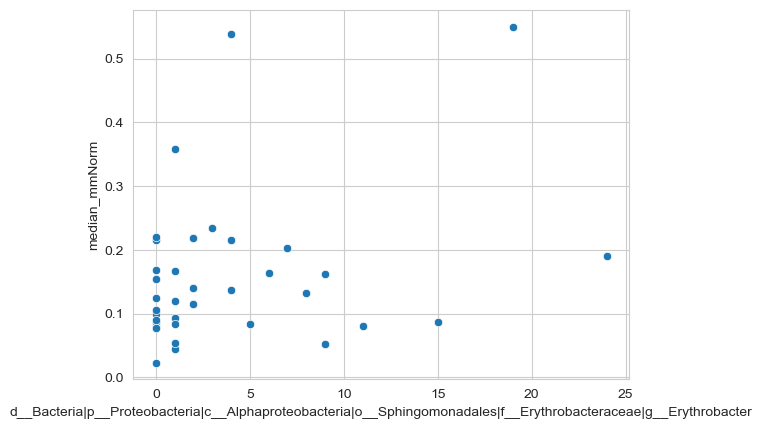

In [18]:
_ = sns.scatterplot(x='d__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Erythrobacteraceae|g__Erythrobacter', y='median_mmNorm', data=erythrobacteraceae_genuses_v9)

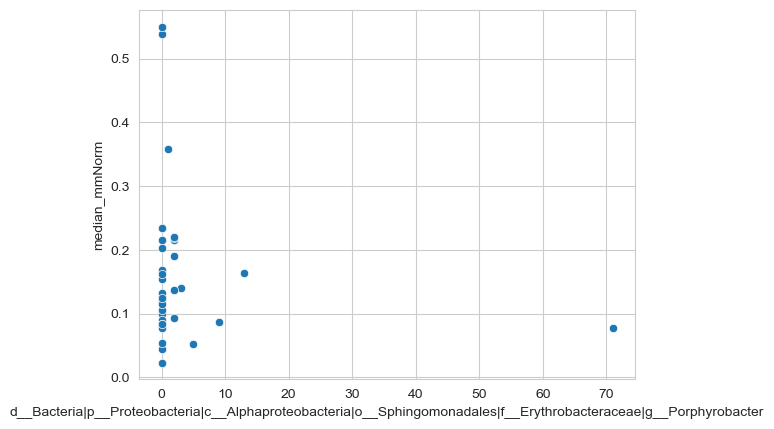

In [19]:
_ = sns.scatterplot(x='d__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Erythrobacteraceae|g__Porphyrobacter', y='median_mmNorm', data=erythrobacteraceae_genuses_v9)

None of the individual genuses that are within the most significant family have compelling results.

## Correlate genuses with separate median titers

In [20]:
v5_DTAPHib_correlations = kraken_genus_abunds_v5.transpose().apply(spearmanr, b=meta_v5['median_mmNorm_DTAPHib']).transpose()
v5_DTAPHib_correlations.columns = ['rho', 'p_value']
v5_DTAPHib_correlations['p_adj'] = p_adjust(v5_DTAPHib_correlations['p_value'])
v5_DTAPHib_correlations = v5_DTAPHib_correlations.sort_values('p_value')
v5_DTAPHib_correlations.head()

,rho,p_value,p_adj
d__Bacteria|p__Bacteroidetes|c__Sphingobacteriia|o__Sphingobacteriales|f__Sphingobacteriaceae|g__Mucilaginibacter,0.473667,0.006174,0.756647
d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Vibrionales|f__Vibrionaceae|g__Paraphotobacterium,0.462952,0.007626,0.756647
d__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Vitreoscilla,0.459636,0.008131,0.756647
d__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Paludibacteraceae|g__Paludibacter,0.444474,0.010813,0.756647
d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Acetobacterium,0.439256,0.011894,0.756647


In [21]:
kraken_genus_abunds_PCV_v5 = kraken_genus_abunds[meta_PCV_v5.index]
kraken_genus_abunds_PCV_v5 = kraken_genus_abunds_PCV_v5.loc[(kraken_genus_abunds_PCV_v5 > 0).sum(axis=1) > kraken_genus_abunds_PCV_v5.shape[1]*.2]
v5_PCV_correlations = kraken_genus_abunds_PCV_v5.transpose().apply(spearmanr, b=meta_PCV_v5['median_mmNorm_PCV']).transpose()
v5_PCV_correlations.columns = ['rho', 'p_value']
v5_PCV_correlations['p_adj'] = p_adjust(v5_PCV_correlations['p_value'])
v5_PCV_correlations = v5_PCV_correlations.sort_values('p_value')
v5_PCV_correlations.head()

,rho,p_value,p_adj
d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Actinobacillus,-0.496471,0.003850,0.99369
d__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Planococcaceae|g__Kurthia,0.415750,0.017956,0.99369
d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Pectobacteriaceae|g__Sodalis,0.378724,0.032558,0.99369
d__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Comamonas,0.368513,0.037953,0.99369
d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Xanthomonadaceae|g__Luteimonas,0.365048,0.039940,0.99369


In [22]:
v6_DTAPHib_correlations = kraken_genus_abunds_v6.transpose().apply(spearmanr, b=meta_v6['median_mmNorm_DTAPHib']).transpose()
v6_DTAPHib_correlations.columns = ['rho', 'p_value']
v6_DTAPHib_correlations['p_adj'] = p_adjust(v6_DTAPHib_correlations['p_value'])
v6_DTAPHib_correlations = v6_DTAPHib_correlations.sort_values('p_value')
v6_DTAPHib_correlations.head()

,rho,p_value,p_adj
d__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Pseudonocardiales|f__Pseudonocardiaceae|g__Amycolatopsis,0.524850,0.001438,0.373509
d__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Propionibacteriales|f__Propionibacteriaceae|g__Propionimicrobium,0.510649,0.002030,0.373509
d__Bacteria|p__Planctomycetes|c__Planctomycetia|o__Planctomycetales|f__Isosphaeraceae|g__Paludisphaera,0.492606,0.003080,0.377794
d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Filifactor,0.478620,0.004191,0.385579
d__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Virgibacillus,0.425994,0.012004,0.791543


In [23]:
kraken_genus_abunds_PCV_v6 = kraken_genus_abunds[meta_PCV_v6.index]
kraken_genus_abunds_PCV_v6 = kraken_genus_abunds_PCV_v6.loc[(kraken_genus_abunds_PCV_v6 > 0).sum(axis=1) > kraken_genus_abunds_PCV_v6.shape[1]*.2]
v6_PCV_correlations = kraken_genus_abunds_PCV_v6.transpose().apply(spearmanr, b=meta_PCV_v6['median_mmNorm_PCV']).transpose()
v6_PCV_correlations.columns = ['rho', 'p_value']
v6_PCV_correlations['p_adj'] = p_adjust(v6_PCV_correlations['p_value'])
v6_PCV_correlations = v6_PCV_correlations.sort_values('p_value')
v6_PCV_correlations.head()

,rho,p_value,p_adj
d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Shigella,-0.607367,0.000139,0.051319
d__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Pseudonocardiales|f__Pseudonocardiaceae|g__Pseudonocardia,0.463529,0.005763,0.663726
d__Bacteria|p__Planctomycetes|c__Planctomycetia|o__Planctomycetales|f__Isosphaeraceae|g__Paludisphaera,0.438488,0.009486,0.663726
d__Bacteria|p__Cyanobacteria|c__Gloeobacteria|o__Gloeobacterales|f__Gloeobacteraceae|g__Gloeobacter,0.425707,0.012068,0.663726
d__Bacteria|p__Deinococcus-Thermus|c__Deinococci|o__Thermales|f__Thermaceae|g__Thermus,0.405208,0.017437,0.663726


In [24]:
v7_DTAPHib_correlations = kraken_genus_abunds_v7.transpose().apply(spearmanr, b=meta_v7['median_mmNorm_DTAPHib']).transpose()
v7_DTAPHib_correlations.columns = ['rho', 'p_value']
v7_DTAPHib_correlations['p_adj'] = p_adjust(v7_DTAPHib_correlations['p_value'])
v7_DTAPHib_correlations = v7_DTAPHib_correlations.sort_values('p_value')
v7_DTAPHib_correlations.head()

,rho,p_value,p_adj
d__Bacteria|p__Chlorobi|c__Chlorobia|o__Chlorobiales|f__Chlorobiaceae|g__Prosthecochloris,0.437694,0.005993,0.987225
d__Bacteria|p__Bacteroidetes|c__Chitinophagia|o__Chitinophagales|f__Chitinophagaceae|g__Flavisolibacter,0.415566,0.009468,0.987225
d__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Gordoniaceae|g__Gordonia,-0.406547,0.011313,0.987225
d__Bacteria|p__Bacteroidetes|c__Cytophagia|o__Cytophagales|f__Hymenobacteraceae|g__Pontibacter,0.400977,0.012599,0.987225
d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|g__Intestinimonas,0.385037,0.016982,0.987225


In [25]:
meta_PCV_v7 = meta_PCV.query("VisitCode == 'V7'")
kraken_genus_abunds_PCV_v7 = kraken_genus_abunds[meta_PCV_v7.index]
kraken_genus_abunds_PCV_v7 = kraken_genus_abunds_PCV_v7.loc[(kraken_genus_abunds_PCV_v7 > 0).sum(axis=1) > kraken_genus_abunds_PCV_v7.shape[1]*.2]
v7_PCV_correlations = kraken_genus_abunds_PCV_v7.transpose().apply(spearmanr, b=meta_PCV_v7['median_mmNorm_PCV']).transpose()
v7_PCV_correlations.columns = ['rho', 'p_value']
v7_PCV_correlations['p_adj'] = p_adjust(v7_PCV_correlations['p_value'])
v7_PCV_correlations = v7_PCV_correlations.sort_values('p_value')
v7_PCV_correlations.head()

,rho,p_value,p_adj
d__Bacteria|p__Firmicutes|c__Tissierellia|o__Tissierellales|f__Peptoniphilaceae|g__Murdochiella,-0.473311,0.002689,0.534605
d__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Polaromonas,0.461895,0.003509,0.534605
d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnoclostridium,0.461210,0.003564,0.534605
d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Shigella,-0.430714,0.006945,0.560036
d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Pectobacteriaceae|g__Pectobacterium,-0.428655,0.007250,0.560036


In [26]:
v9_DTAPHib_correlations = kraken_genus_abunds_v9.transpose().apply(spearmanr, b=meta_v9['median_mmNorm_DTAPHib']).transpose()
v9_DTAPHib_correlations.columns = ['rho', 'p_value']
v9_DTAPHib_correlations['p_adj'] = p_adjust(v9_DTAPHib_correlations['p_value'])
v9_DTAPHib_correlations = v9_DTAPHib_correlations.sort_values('p_value')
v9_DTAPHib_correlations.head()

,rho,p_value,p_adj
d__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Eggerthellales|f__Eggerthellaceae|g__Phoenicibacter,0.471128,0.003249,0.907846
d__Bacteria|p__Acidobacteria|c__Solibacteres|o__Solibacterales|f__Solibacteraceae|g__Candidatus_Solibacter,0.458375,0.004329,0.907846
d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Terriglobus,0.381523,0.019808,0.907846
d__Bacteria|p__Firmicutes|c__Tissierellia|o__Tissierellales|f__Peptoniphilaceae|g__Peptoniphilus,0.380168,0.020286,0.907846
d__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Ottowia,0.377069,0.021417,0.907846


In [27]:
meta_PCV_v9 = meta_PCV.query("VisitCode == 'V9'")
kraken_genus_abunds_PCV_v9 = kraken_genus_abunds[meta_PCV_v9.index]
kraken_genus_abunds_PCV_v9 = kraken_genus_abunds_PCV_v9.loc[(kraken_genus_abunds_PCV_v9 > 0).sum(axis=1) > kraken_genus_abunds_PCV_v9.shape[1]*.2]
v9_PCV_correlations = kraken_genus_abunds_PCV_v9.transpose().apply(spearmanr, b=meta_PCV_v9['median_mmNorm_PCV']).transpose()
v9_PCV_correlations.columns = ['rho', 'p_value']
v9_PCV_correlations['p_adj'] = p_adjust(v9_PCV_correlations['p_value'])
v9_PCV_correlations = v9_PCV_correlations.sort_values('p_value')
v9_PCV_correlations.head()

,rho,p_value,p_adj
d__Bacteria|p__Kiritimatiellaeota|c__Kiritimatiellae|o__Kiritimatiellales|f__Kiritimatiellaceae|g__Kiritimatiella,-0.475762,0.002919,0.607965
d__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodobacterales|f__Hyphomonadaceae|g__Maricaulis,-0.470493,0.003296,0.607965
d__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiaceae|g__Ralstonia,-0.458693,0.004299,0.607965
d__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Planococcaceae|g__Planococcus,0.458073,0.004358,0.607965
d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Immundisolibacterales|f__Immundisolibacteraceae|g__Immundisolibacter,-0.444494,0.005847,0.652536


## Correlate families with separate median titers

In [28]:
v5_DTAPHib_correlations = kraken_family_abunds_v5.transpose().apply(spearmanr, b=meta_v5['median_mmNorm_DTAPHib']).transpose()
v5_DTAPHib_correlations.columns = ['rho', 'p_value']
v5_DTAPHib_correlations['p_adj'] = p_adjust(v5_DTAPHib_correlations['p_value'])
v5_DTAPHib_correlations = v5_DTAPHib_correlations.sort_values('p_value')
v5_DTAPHib_correlations.head()

,rho,p_value,p_adj
d__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Paludibacteraceae,0.444474,0.010813,0.612366
d__Bacteria|p__Bacteroidetes|c__Chitinophagia|o__Chitinophagales|f__Chitinophagaceae,0.407051,0.020769,0.612366
d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae,0.397908,0.024108,0.612366
d__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae,0.396245,0.024761,0.612366
d__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Chromobacteriaceae,0.395324,0.025128,0.612366


In [29]:
kraken_family_abunds_PCV_v5 = kraken_family_abunds[meta_PCV_v5.index]
kraken_family_abunds_PCV_v5 = kraken_family_abunds_PCV_v5.loc[(kraken_family_abunds_PCV_v5 > 0).sum(axis=1) > kraken_family_abunds_PCV_v5.shape[1]*.2]
v5_PCV_correlations = kraken_family_abunds_PCV_v5.transpose().apply(spearmanr, b=meta_PCV_v5['median_mmNorm_PCV']).transpose()
v5_PCV_correlations.columns = ['rho', 'p_value']
v5_PCV_correlations['p_adj'] = p_adjust(v5_PCV_correlations['p_value'])
v5_PCV_correlations = v5_PCV_correlations.sort_values('p_value')
v5_PCV_correlations.head()

,rho,p_value,p_adj
d__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfovibrionales|f__Desulfovibrionaceae,0.425139,0.015283,0.898323
d__Bacteria|p__Synergistetes|c__Synergistia|o__Synergistales|f__Synergistaceae,0.416756,0.017652,0.898323
d__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Propionibacteriales|f__Propionibacteriaceae,-0.404843,0.021538,0.898323
d__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfuromonadales|f__Desulfuromonadaceae,0.402286,0.022458,0.898323
d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Methylococcales|f__Methylococcaceae,0.336368,0.059789,0.966413


In [30]:
v6_DTAPHib_correlations = kraken_family_abunds_v6.transpose().apply(spearmanr, b=meta_v6['median_mmNorm_DTAPHib']).transpose()
v6_DTAPHib_correlations.columns = ['rho', 'p_value']
v6_DTAPHib_correlations['p_adj'] = p_adjust(v6_DTAPHib_correlations['p_value'])
v6_DTAPHib_correlations = v6_DTAPHib_correlations.sort_values('p_value')
v6_DTAPHib_correlations.head()

,rho,p_value,p_adj
d__Bacteria|p__Planctomycetes|c__Planctomycetia|o__Planctomycetales|f__Isosphaeraceae,0.528937,0.001299,0.232541
d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae,0.402223,0.018364,0.983715
d__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Propionibacteriales|f__Propionibacteriaceae,0.377459,0.027754,0.983715
d__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfarculales|f__Desulfarculaceae,0.352386,0.040956,0.983715
d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Oceanospirillales|f__Halomonadaceae,0.349790,0.042572,0.983715


In [31]:
kraken_family_abunds_PCV_v6 = kraken_family_abunds[meta_PCV_v6.index]
kraken_family_abunds_PCV_v6 = kraken_family_abunds_PCV_v6.loc[(kraken_family_abunds_PCV_v6 > 0).sum(axis=1) > kraken_family_abunds_PCV_v6.shape[1]*.2]
v6_PCV_correlations = kraken_family_abunds_PCV_v6.transpose().apply(spearmanr, b=meta_PCV_v6['median_mmNorm_PCV']).transpose()
v6_PCV_correlations.columns = ['rho', 'p_value']
v6_PCV_correlations['p_adj'] = p_adjust(v6_PCV_correlations['p_value'])
v6_PCV_correlations = v6_PCV_correlations.sort_values('p_value')
v6_PCV_correlations.head()

,rho,p_value,p_adj
d__Bacteria|p__Planctomycetes|c__Planctomycetia|o__Planctomycetales|f__Isosphaeraceae,0.475452,0.004486,0.803024
d__Bacteria|p__Cyanobacteria|c__Gloeobacteria|o__Gloeobacterales|f__Gloeobacteraceae,0.425707,0.012068,0.985283
d__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfarculales|f__Desulfarculaceae,0.389470,0.022800,0.985283
d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Alteromonadales|f__Shewanellaceae,-0.383285,0.025250,0.985283
d__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Cellulomonadaceae,-0.365584,0.033488,0.985283


In [32]:
v7_DTAPHib_correlations = kraken_family_abunds_v7.transpose().apply(spearmanr, b=meta_v7['median_mmNorm_DTAPHib']).transpose()
v7_DTAPHib_correlations.columns = ['rho', 'p_value']
v7_DTAPHib_correlations['p_adj'] = p_adjust(v7_DTAPHib_correlations['p_value'])
v7_DTAPHib_correlations = v7_DTAPHib_correlations.sort_values('p_value')
v7_DTAPHib_correlations.head()

,rho,p_value,p_adj
d__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Gordoniaceae,-0.406547,0.011313,0.988599
d__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Chelatococcaceae,0.311641,0.056826,0.988599
d__Bacteria|p__Cyanobacteria|o__Synechococcales|f__Prochloraceae,-0.308002,0.059938,0.988599
d__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Myxococcales|f__Archangiaceae,0.304564,0.063001,0.988599
d__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Marinilabiliales|f__Marinifilaceae,0.292587,0.074649,0.988599


In [33]:
kraken_family_abunds_PCV_v7 = kraken_family_abunds[meta_PCV_v7.index]
kraken_family_abunds_PCV_v7 = kraken_family_abunds_PCV_v7.loc[(kraken_family_abunds_PCV_v7 > 0).sum(axis=1) > kraken_family_abunds_PCV_v7.shape[1]*.2]
v7_PCV_correlations = kraken_family_abunds_PCV_v7.transpose().apply(spearmanr, b=meta_PCV_v7['median_mmNorm_PCV']).transpose()
v7_PCV_correlations.columns = ['rho', 'p_value']
v7_PCV_correlations['p_adj'] = p_adjust(v7_PCV_correlations['p_value'])
v7_PCV_correlations = v7_PCV_correlations.sort_values('p_value')
v7_PCV_correlations.head()

,rho,p_value,p_adj
d__Bacteria|p__Thermodesulfobacteria|c__Thermodesulfobacteria|o__Thermodesulfobacteriales|f__Thermodesulfobacteriaceae,0.361319,0.025826,0.992195
d__Bacteria|p__Nitrospirae|c__Nitrospira|o__Nitrospirales|f__Nitrospiraceae,-0.359667,0.026563,0.992195
d__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae,0.351021,0.030707,0.992195
d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Yersiniaceae,-0.341618,0.035804,0.992195
d__Bacteria|p__Planctomycetes|c__Planctomycetia|o__Planctomycetales|f__Isosphaeraceae,0.331231,0.042216,0.992195


In [34]:
v9_DTAPHib_correlations = kraken_family_abunds_v9.transpose().apply(spearmanr, b=meta_v9['median_mmNorm_DTAPHib']).transpose()
v9_DTAPHib_correlations.columns = ['rho', 'p_value']
v9_DTAPHib_correlations['p_adj'] = p_adjust(v9_DTAPHib_correlations['p_value'])
v9_DTAPHib_correlations = v9_DTAPHib_correlations.sort_values('p_value')
v9_DTAPHib_correlations.head()

,rho,p_value,p_adj
d__Bacteria|p__Acidobacteria|c__Solibacteres|o__Solibacterales|f__Solibacteraceae,0.458375,0.004329,0.807624
d__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfuromonadales|f__Desulfuromonadaceae,0.420602,0.009540,0.807624
d__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfobacterales|f__Desulfobacteraceae,0.412569,0.011162,0.807624
d__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae,-0.355758,0.030697,0.807624
d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae,0.354837,0.031163,0.807624


In [35]:
kraken_family_abunds_PCV_v9 = kraken_family_abunds[meta_PCV_v9.index]
kraken_family_abunds_PCV_v9 = kraken_family_abunds_PCV_v9.loc[(kraken_family_abunds_PCV_v9 > 0).sum(axis=1) > kraken_family_abunds_PCV_v9.shape[1]*.2]
v9_PCV_correlations = kraken_family_abunds_PCV_v9.transpose().apply(spearmanr, b=meta_PCV_v9['median_mmNorm_PCV']).transpose()
v9_PCV_correlations.columns = ['rho', 'p_value']
v9_PCV_correlations['p_adj'] = p_adjust(v9_PCV_correlations['p_value'])
v9_PCV_correlations = v9_PCV_correlations.sort_values('p_value')
v9_PCV_correlations.head()

,rho,p_value,p_adj
d__Bacteria|p__Kiritimatiellaeota|c__Kiritimatiellae|o__Kiritimatiellales|f__Kiritimatiellaceae,-0.475762,0.002919,0.423921
d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Immundisolibacterales|f__Immundisolibacteraceae,-0.444494,0.005847,0.423921
d__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Planococcaceae,0.435041,0.007126,0.423921
d__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Brevibacteriaceae,0.433598,0.007341,0.423921
d__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodobacterales|f__Hyphomonadaceae,-0.420470,0.009565,0.441881


All significance goes away when we split between DTAPHib and PCV specific titers.